In [1]:
#importing useful packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors
from matplotlib.patches import Ellipse
from scipy.ndimage import rotate
from astropy import units as u

from astropy.io import fits
import astropy.units as u
import astropy.constants as C
from scipy.optimize import curve_fit

from tqdm import tqdm
import os


In [2]:
os.getcwd()

'/Users/majiduzbak/Desktop/MSc/Thesis'

In [3]:
# This is due to data being saved somewhere else
dat = '/Users/majiduzbak/Desktop/MSc/Thesis/Data/'
dat

'/Users/majiduzbak/Desktop/MSc/Thesis/Data/'

In [4]:
#importing and defining datacube

CO = fits.open(dat+'Ced110IRS4_SBLB_C18O_robust_0.5.pbcor.fits')
#CO = fits.open(dat+'Ced110IRS4_SBLB_13CO_robust_0.5.pbcor.fits')


data_CO = CO[0].data
header_CO = CO[0].header
#header_CO  #extracting the header info
print(data_CO.shape)
data_CO[20:60,:,:]
header_CO

(120, 4000, 4000)


SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    3                                                  
NAXIS1  =                 4000                                                  
NAXIS2  =                 4000                                                  
NAXIS3  =                  120                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   3.179636487416E-05                                                  
BMIN    =   2.274442843615E-05                                                  
BPA     =  -8.994931199112E+00                                                  
BTYPE   = 'Intensity'       

In [5]:


#============== FREQUENCY AND VELOCITY CONVERSION ================#

#define frequency (number of channels(from 0) + 1 - reference pixel)*value (pixel) + value of reference pixel (GHz)
freq_CO = ((np.arange(header_CO['NAXIS3'])+1-header_CO['CRPIX3'])*header_CO['CDELT3']+header_CO['CRVAL3'])#/1e9

#speed of light [km/s]
c = C.c.cgs.value * 1e-5
#rest freguency [Hz]
f_0_CO = header_CO['RESTFRQ']
#measured frequency [Hz]
f_meas_CO = freq_CO#*1e9

#measured wavelength [m]
lambda_meas_CO = c/f_meas_CO
#rest wavelength [m]
lambda_0_CO = c/f_0_CO

#delta wavelength [m]
delta_lambda_CO = lambda_meas_CO - lambda_0_CO

#radial velocity [km/s] v = c * delta_lambda/lambda 0
v_CO = c * (delta_lambda_CO/lambda_0_CO)

delta_freq_CO = freq_CO[0] - freq_CO[1] #frequency width

#convert to velocity
delta_v_CO = v_CO[1]-v_CO[0] #velocity width

#integrated emission (Jy/beam km/s)
int_emis_CO_L = data_CO[20:60,:,:].sum(axis=0) * delta_v_CO  #these regions has been chosen via CARTA
int_emis_CO_R = data_CO[60:100,:,:].sum(axis=0) * delta_v_CO



#============== NOISE ================

#Defining noise (region of integrated emission map toward one of the edge)
background_CO_L = int_emis_CO_L[1000:1200,1000:1200]  #Left side / blue shifted disk
background_CO_R = int_emis_CO_R[1300:1600,1300:1600]  #Rightt side / red shifted disk




#in the case of the sum of noise giving 0, the rms is the same as std.
sigma_rms_CO_L = np.sqrt(np.mean(background_CO_L**2))  
sigma_rms_CO_R = np.sqrt(np.mean(background_CO_R**2))

#=========== MAP COORDINATES (offset) ===========

#defining arcseconds on axes with source at origin
xaxis_CO = ((np.arange(header_CO['NAXIS1'])+1-(header_CO['CRPIX1']))*header_CO['CDELT1']*60.0**2)#+0.27)
yaxis_CO = (np.arange(header_CO['NAXIS2'])+1-(header_CO['CRPIX2']))*header_CO['CDELT2']*60.0**2#+0.11
vaxis2 = (np.arange(header_CO['NAXIS3'])-(header_CO['CRPIX3']-1))*header_CO['CDELT3']/1000.0+header_CO['CRVAL3']/1000.0

#meshgrid
X_CO, Y_CO = np.meshgrid(xaxis_CO, yaxis_CO)

#defining beam in arcsec
bmaj = header_CO['BMAJ']*3600
bmin = header_CO['BMIN']*3600

In [6]:
#plt.imshow(data_CO[60,:,:])

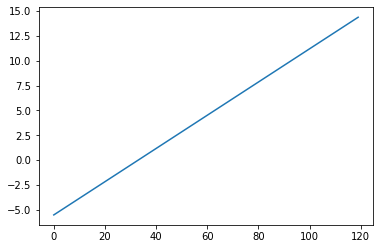

In [7]:
plt.plot(v_CO)

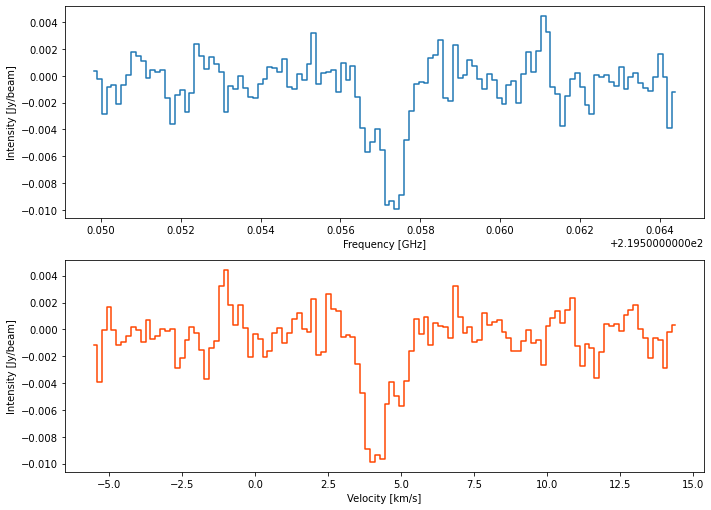

In [8]:
#plotting (go from Jy to Jy/beam??)
plt.figure(2, figsize = (10,7))
plt.subplot(211)
plt.plot((freq_CO*1e-9), data_CO[:,2000,2000],drawstyle='steps-mid') #[stokes,freq,posx, posy]
plt.xlabel('Frequency [GHz]')
plt.ylabel('Intensity [Jy/beam]')

plt.subplot(212)
plt.plot(v_CO, data_CO[:,2000,2000],drawstyle='steps-mid', color = 'OrangeRed')
plt.tight_layout()
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [Jy/beam]')
#plt.savefig('I_vs_vel.png')
plt.show();

In [9]:
Y_CO.shape

(4000, 4000)

## Plotting the contours (Disc)

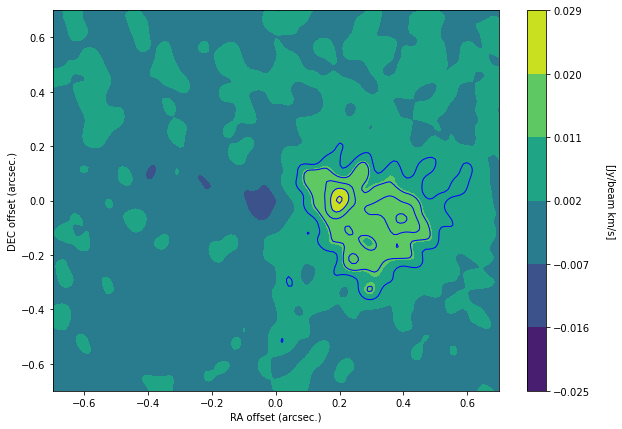

In [10]:
#plotting
plt.figure(1, figsize = (10,7))
ax1 = plt.contourf(X_CO,Y_CO,int_emis_CO_L[:,:],np.arange(-0.025,0.03,0.009))#, levels = np.arange(-1,5,0.1))
plt.contour(X_CO, Y_CO, int_emis_CO_L, np.arange(2*sigma_rms_CO_L,10*sigma_rms_CO_L,sigma_rms_CO_L), linewidths = 1, colors = 'blue')

#adding beam with Position Angle -2.375362396240E+01 (added 90 to get)
plt.gca().add_patch(Ellipse((4, -4), width=bmaj, height=bmin, edgecolor='white', angle = 90+header_CO['BPA'], facecolor='none', linewidth=1.40))

plt.xlabel('RA offset (arcsec.)')
plt.ylabel('DEC offset (arcsec.)')

plt.xlim(-0.7,0.7)
plt.ylim(-0.7,0.7)

#colorbar
cbar = plt.colorbar(ax1)
cbar.set_label('[Jy/beam km/s]', labelpad=25, y=0.5, rotation=270);


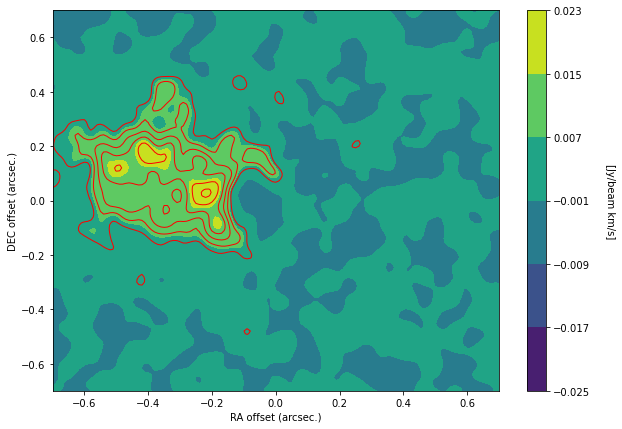

In [11]:
#plotting
plt.figure(2, figsize = (10,7))
ax2 = plt.contourf(X_CO,Y_CO,int_emis_CO_R[:,:],np.arange(-0.025,0.024,0.008))#, levels = np.arange(-1,5,0.1))
plt.contour(X_CO, Y_CO, int_emis_CO_R, np.arange(2*sigma_rms_CO_R,10*sigma_rms_CO_R,sigma_rms_CO_R), linewidths = 1, colors = 'red')

#adding beam with Position Angle -2.375362396240E+01 (added 90 to get)
plt.gca().add_patch(Ellipse((4, -4), width=bmaj, height=bmin, edgecolor='white', angle = 90+header_CO['BPA'], facecolor='none', linewidth=1.40))

plt.xlabel('RA offset (arcsec.)')
plt.ylabel('DEC offset (arcsec.)')

plt.xlim(-0.7,0.7)
plt.ylim(-0.7,0.7)

#colorbar
cbar = plt.colorbar(ax2)
cbar.set_label('[Jy/beam km/s]', labelpad=25, y=0.5, rotation=270);

(-0.5, 0.7)

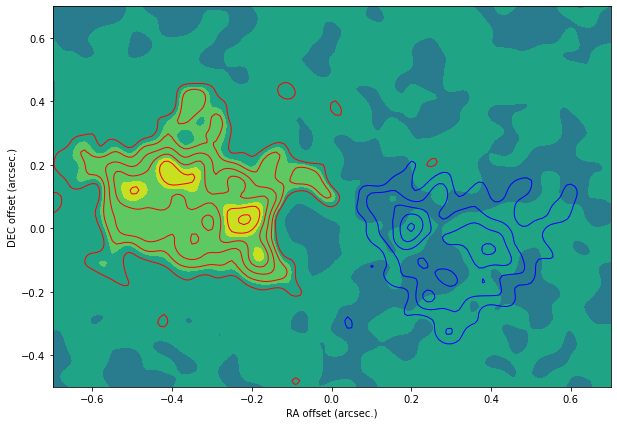

In [12]:
#plotting
#fig, (ax1, ax2) = plt.subplots(1, 2)
plt.figure(figsize = (10,7))

ax1 = plt.contourf(X_CO, Y_CO,int_emis_CO_L[:,:],np.arange(-0.025,0.03,0.009))#, levels = np.arange(-1,5,0.1))
c1 = plt.contour(X_CO, Y_CO,int_emis_CO_L, np.arange(2*sigma_rms_CO_L,10*sigma_rms_CO_L,sigma_rms_CO_L), linewidths = 1, colors='blue')

ax2 = plt.contourf(X_CO, Y_CO,int_emis_CO_R[:,:],np.arange(-0.025,0.024,0.008))#, levels = np.arange(-1,5,0.1))
c2 = plt.contour(X_CO, Y_CO,int_emis_CO_R, np.arange(2*sigma_rms_CO_R,10*sigma_rms_CO_R,sigma_rms_CO_R), linewidths = 1, colors='red')

#adding beam with Position Angle -2.375362396240E+01 (added 90 to get)
plt.gca().add_patch(Ellipse((4, -4), width=bmaj, height=bmin, edgecolor='white', angle = 90+header_CO['BPA'], facecolor='none', linewidth=1.40))
plt.xlabel('RA offset (arcsec.)')
plt.ylabel('DEC offset (arcsec.)')

plt.xlim(-0.7,0.7)
plt.ylim(-0.5,0.7)

#plt.scatter(0, 0, color="k", marker="*")

#colorbar
#cbar = plt.colorbar(c1)
#cbar.set_label('[Jy/beam km/s]', labelpad=25, y=0.5, rotation=270);

## loading the continuum data

In [13]:
#hdulist=fits.open(dat+'Ced110IRS4_SBLB_continuum_robust_0.5.pbcor.tt0.fits')
hdulist=fits.open(dat+'Ced110IRS4_SBLB_continuum_robust_0.5.pbcor_5arcsec.fits')


data=hdulist[0].data
header=hdulist[0].header
xaxis=(np.arange(header['NAXIS1'])-(header['CRPIX1']-1))*header['CDELT1']*60.0**2
yaxis=(np.arange(header['NAXIS2'])-(header['CRPIX2']-1))*header['CDELT2']*60.0**2

X, Y = np.meshgrid(xaxis, yaxis)
#header['BUNIT']
header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    2                                                  
NAXIS1  =                 1261                                                  
NAXIS2  =                  990                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   2.008726199468E-05                                                  
BMIN    =   1.307909894321E-05                                                  
BPA     =  -7.366089820862E+00                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'Ced110IRS4'      

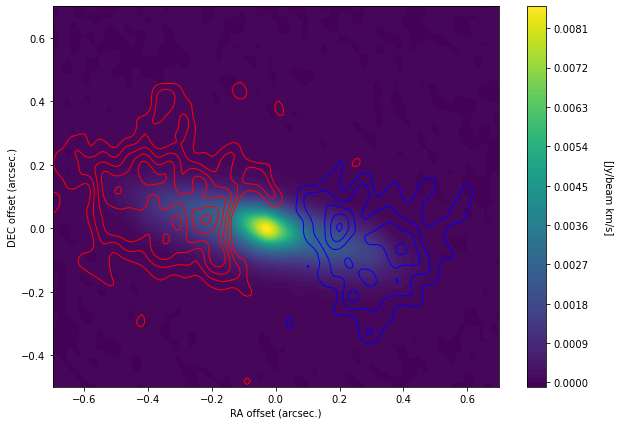

In [14]:
#plotting the continuum with contour
#fig, (ax1, ax2) = plt.subplots(1, 2)
plt.figure(figsize = (10,7))

c1 = plt.contourf(X_CO, Y_CO,int_emis_CO_L[:,:],np.arange(-0.025,0.03,0.009))#, levels = np.arange(-1,5,0.1))
c = plt.contour(X_CO, Y_CO,int_emis_CO_L, np.arange(2*sigma_rms_CO_L,10*sigma_rms_CO_L,sigma_rms_CO_L), linewidths = 1, colors='blue')

c2 = plt.contourf(X_CO, Y_CO,int_emis_CO_R[:,:],np.arange(-0.025,0.024,0.008))#, levels = np.arange(-1,5,0.1))
c = plt.contour(X_CO, Y_CO,int_emis_CO_R, np.arange(2*sigma_rms_CO_R,10*sigma_rms_CO_R,sigma_rms_CO_R), linewidths = 1, colors='red')

#adding beam with Position Angle -2.375362396240E+01 (added 90 to get)
plt.gca().add_patch(Ellipse((4, -4), width=bmaj, height=bmin, edgecolor='white', angle = 90+header_CO['BPA'], facecolor='none', linewidth=1.40))
plt.xlabel('RA offset (arcsec.)')
plt.ylabel('DEC offset (arcsec.)')

plt.xlim(-0.7,0.7)
plt.ylim(-0.5,0.7)

plt.scatter(0, 0, color="k", marker="*")
cx = plt.contourf(X,Y,data,100);

#colorbar
cbar = plt.colorbar(cx)
cbar.set_label('[Jy/beam km/s]', labelpad=25, y=0.5, rotation=270);

#plt.savefig('cont_cont.png')

## Calculating sigma / RMS, so we know that these contour are good enough

In [15]:
sigma_i = (np.mean([data_CO[100:119,1900:2100,1900:2100]**2]))**0.5
sigma_I = np.sqrt(40)*sigma_i*delta_v_CO
print('sigma:',sigma_I)
print('3sigma:',3*sigma_I)
print('6sigma:',6*sigma_I)

sigma: 0.0014947199500863167
3sigma: 0.00448415985025895
6sigma: 0.0089683197005179


In [16]:
## Is there asymetry on the disc minor and major axis? 
## these to plots shows there is asymetry and this means that the object has some inclination
data.shape

(990, 1261)

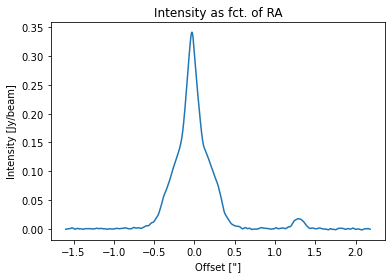

In [17]:
dx = data[370:600,:].sum(axis=0)
plt.plot(xaxis, dx)
plt.title('Intensity as fct. of RA')
plt.ylabel('Intensity [Jy/beam]')
plt.xlabel('Offset ["]');
#plt.savefig('IvsRA')

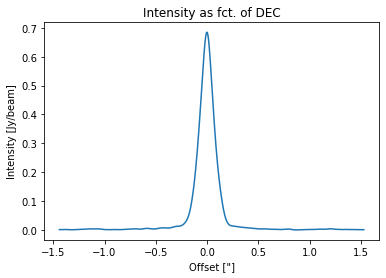

In [18]:
dy = data[:,255:915].sum(axis=1)
plt.plot(yaxis, dy)
plt.title('Intensity as fct. of DEC')
plt.ylabel('Intensity [Jy/beam]')
plt.xlabel('Offset ["]');
#plt.savefig('IvsDEC')

## Loading data after fitting a Gaussian via CASA

In [19]:
#importing and defining data
Gauss = fits.open(dat+'Ced110IRS4_SBLB_continuum_robust_0.5.pbcor_gauss.fits')

data_G = Gauss[0].data

header_G = Gauss[0].header
#header_G

#importing and defining data
Residual = fits.open(dat+'Ced110IRS4_SBLB_continuum_robust_0.5.pbcor_residual.fits')

data_R = Residual[0].data

header_R = Residual[0].header
#header_R

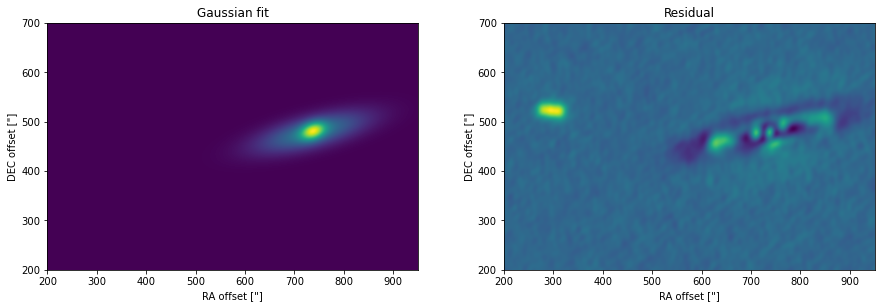

In [20]:
plt.figure(2, figsize = (15,10))

plt.subplot(221)
plt.imshow(data_G)

plt.title('Gaussian fit')
plt.ylim(200,700)
plt.xlim(200,950)
plt.xlabel('RA offset ["]')
plt.ylabel('DEC offset ["]')

plt.subplot(222)
plt.imshow(data_R)

plt.title('Residual')
plt.ylim(200,700)
plt.xlim(200,950)
plt.xlabel('RA offset ["]')
plt.ylabel('DEC offset ["]')
plt.show();
#plt.savefig('GaussResid.png')

In [21]:
# logfile of the fit
with open(dat+'gauss_values.txt') as f:
    contents = f.read()
    print(contents)

****** Fit performed at Tue May 30 13:54:20 2023******

Input parameters ---
       --- imagename:           /Users/majiduzbak/Desktop/MSc/8.Prep-projekt/Data/Ced110IRS4_SBLB_continuum_robust_0.5.pbcor_5arcsec.fits
       --- region:              
       --- channel:             0
       --- stokes:              
       --- mask:                
       --- include pixel range: []
       --- exclude pixel range: []
       --- initial estimates:   Peak, X, Y, a, b, PA
                                0.01, 730, 470, 0.1arcsec, 0.03arcsec, -7deg
0.01, 730, 470, 0.1arcsec, 0.03arcsec, -7deg

*** Details of fit for channel number 0
Number of pixels used in fit: 59965
Input and residual image statistics (to be used as a rough guide only as to goodness of fit)
       --- Standard deviation of input image: 0.00118312 Jy
       --- Standard deviation of residual image: 7.82998e-05 Jy
       --- RMS of input image: 0.001353 Jy
       --- RMS of residual image: 7.8301e-05 Jy

Fit on Ced110IRS4_SBL

In [22]:
# importing pandas
import pandas as pd
  
# read text file into pandas DataFrame
dg = pd.read_csv(dat+'gauss_values.txt', sep="\t")#,skiprows=9)
  
# display DataFrame
#dg = df.sort_values(by='wavelength (mu)')
print(dg)

   ****** Fit performed at Tue May 30 13:54:20 2023******
0                                Input parameters ---    
1          --- imagename:           /Users/majiduz...    
2                           --- region:                  
3                          --- channel:             0    
4                           --- stokes:                  
..                                                ...    
61               --- Integrated:   77.37 +/- 0.96 mJy    
62         --- Peak:         3.466 +/- 0.041 mJy/beam    
63                                 --- Polarization:     
64                                       Spectrum ---    
65        --- frequency:        1000.000 MHz (29.9...    

[66 rows x 1 columns]


In [23]:
# Defining the results from logfile, use the deconvolved values 
major = 528.4  # +/- 6.8 marcsec
minor = 125.1  # +/- 1.9 marcsec
FluxT = 77.37  # +/- 0.96 mJy
#peakF = 3.466  # +/- 0.041 mJy/beam
Posangle = 103.78 # +/- 0.27 deg

In [24]:
FluxT

77.37

In [25]:
# Inclination of the disc. by major and minor axis
InclRad = (np.arccos(minor/major))
InclDeg = InclRad * (180/np.pi)
print('Inclination in radians:', InclRad, 'inclination in degrees:',InclDeg) #this is the face on incklilnation of the source

Inclination in radians: 1.3317744133583114 inclination in degrees: 76.30505314894236


13.780000000000001


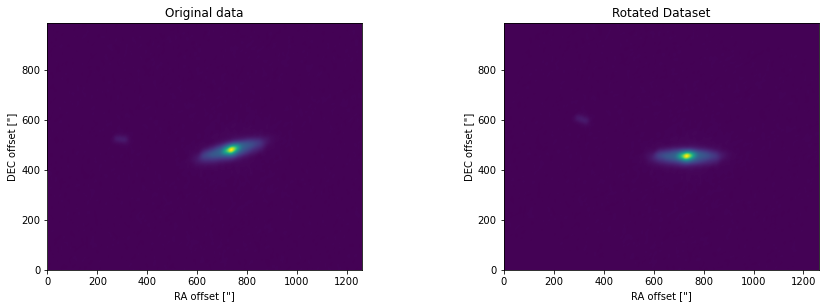

In [26]:
# Rotation angle in degrees
sys_Deg = Posangle-90 # inclination from the coordinate system, by using the poasition angle and substracting 90degrees
print(sys_Deg)
#reduced continuum data
hdulist=fits.open(dat+'Ced110IRS4_SBLB_continuum_robust_0.5.pbcor_5arcsec.fits')
data=hdulist[0].data


# Rotate the dataset with bilinear interpolation (order=1)
rotated_dataset = rotate(data, sys_Deg, reshape=False, order=1)

# plotting the before and after rotating the data
plt.figure(2, figsize = (15,10))

plt.subplot(221)
plt.imshow(data)
plt.gca().invert_yaxis()


plt.title('Original data')
plt.xlabel('RA offset ["]')
plt.ylabel('DEC offset ["]')

plt.subplot(222)
plt.imshow(rotated_dataset)

plt.title('Rotated Dataset')
plt.xlabel('RA offset ["]')
plt.ylabel('DEC offset ["]')
plt.gca().invert_yaxis()

plt.show();
#plt.savefig('rotate.png')

In [27]:
200*4*7.5

6000.0

# finding the mass_dust by eqaution from Tobin/Kauffmann


In [28]:

FluxT = 7.737e-28 * (u.kg)/ (u.s**2)
kappa = 0.184 * (u.m**2)/(u.kg) #Kappa is the value from the TObin article
wave = 0.87 * u.mm
wave = wave.to(u.m)
k_b = (1.380649e-23) * (u.m**82*u.kg)/(u.s**2 * u.K)
T_dust = 43 * u.K
c = 2.99e8 * (u.m)/(u.s)
D = 5.955357732e18 * u.m
nu = c/wave

B_planck = 2*(nu**2) * k_b * T_dust / (c**2) 


M_dust = ((D**2) * FluxT) / (kappa * B_planck)
M_dust

<Quantity 9.50664449e+25 kg / m80>

In [29]:
# in solarmass
M_sun = 2e30 * u.kg

M_disc = M_dust / M_sun

#Mass dust in solarmasses
print('Mass:', M_disc, 'solarmass')


Mass: 4.7533222474488166e-05 1 / m80 solarmass


In [30]:
M_disc*100

<Quantity 0.00475332 1 / m80>

In [31]:
X_CO.shape

(4000, 4000)


## PV and Kepler fit

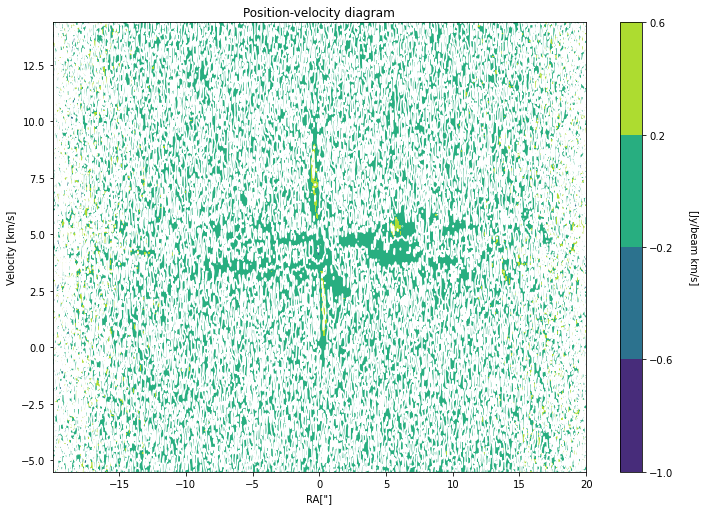

In [32]:
# P-V Diagram
PV = plt.figure(figsize = (10,7))
ke = plt.contourf(X_CO[0,:], v_CO, data_CO[:,1960:2040,:].sum(axis=1),np.arange(-1,1,0.4))
plt.contour(X_CO[0,:], v_CO, data_CO[:,1960:2040,:].sum(axis=1), colors='white')


#colorbar
cbar = plt.colorbar(ke)
cbar.set_label('[Jy/beam km/s]', labelpad=25, y=0.5, rotation=270);

plt.title('Position-velocity diagram')
plt.tight_layout()
plt.xlabel('RA["]')
plt.ylabel('Velocity [km/s]')
#plt.xlim(-2,2)
plt.show();

In [33]:

x_cen = X_CO[0,int(len(X_CO[0])/2-200):int(len(X_CO[0])/2+200)]

data_CO[:,1960:2040,1800:2200].sum(axis=1).shape

(120, 400)

In [34]:
def kepler(x,m):
    #G = 6.67430e-11  # Gravitational constant #m^3  kg^-1 s^-2
    G = 6.67430e-20 #km^3 kg^-1 s^-2
    r = np.abs(x)
    v = -x/abs(x)*np.sqrt((G * m) / r)
    #print(np.min(abs(m)))
    return v

x_left = ((190) * x_cen[159:199])*149597871 # from arcsecs to km (x_cen is in arcsec)

x_right = ((190) * x_cen[201:241])*149597871 # from arcsecs to km


/var/folders/4d/5886zydn3lbfw58r87hv94q80000gn/T/ipykernel_21776/4186182093.py:5: RuntimeWarning: invalid value encountered in sqrt
  v = -x/abs(x)*np.sqrt((G * m) / r)


Fitted Mass right side, M = 0.7063155158151976 solarmasses
Fitted Mass left side, M = 7.684340744095942e-17 solarmasses


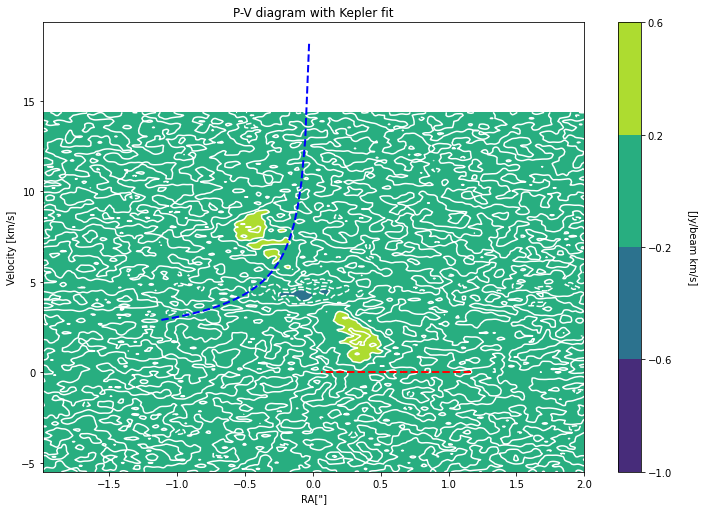

In [35]:

# Define the initial estimate for the mass M
initial_M = 1.989e30  # Initial estimate for M the guess from 2e20- and higher gives the dsame values for M
M_sun = initial_M * u.kg

# Perform the curve fitting
param_right, cov_right = curve_fit(kepler, x_right, v_CO[60:100], p0=[initial_M])
param_left, cov_left = curve_fit(kepler, x_left, v_CO[20:60], p0=[initial_M])

# Retrieve the fitted parameters
fitted_M_right = param_right[0]
fitted_M_left = param_left[0]

M_R = fitted_M_right * u.kg /M_sun
M_L = fitted_M_left * u.kg /M_sun
print("Fitted Mass right side, M =", M_R, 'solarmasses')
print("Fitted Mass left side, M =", M_L, 'solarmasses')

# P-V Diagram
PV = plt.figure(figsize = (10,7))
ke = plt.contourf(x_cen, v_CO, data_CO[:,1960:2040,1800:2200].sum(axis=1),np.arange(-1,1,0.4))
plt.contour(x_cen, v_CO, data_CO[:,1960:2040,1800:2200].sum(axis=1), colors='white')

plt.plot(x_right/1e10, kepler(x_right, fitted_M_right), linestyle='--', linewidth=2, color='blue');
plt.plot(x_left/1e10, kepler(x_left, fitted_M_left), linestyle='--', linewidth=2, color='red');

#colorbar
cbar = plt.colorbar(ke)
cbar.set_label('[Jy/beam km/s]', labelpad=25, y=0.5, rotation=270);

plt.title('P-V diagram with Kepler fit')
plt.tight_layout()
plt.xlabel('RA["]')
plt.ylabel('Velocity [km/s]')
#plt.xlim(-2,2)
#plt.ylim(-10,10)
#plt.savefig('PVkepler.png')
plt.show();

In [36]:
type(x_cen)
x_cen[159:199].shape
x_cen[201:241].shape
np.concatenate((x_cen[159:200], x_cen[200:241]))

array([ 0.41,  0.4 ,  0.39,  0.38,  0.37,  0.36,  0.35,  0.34,  0.33,
        0.32,  0.31,  0.3 ,  0.29,  0.28,  0.27,  0.26,  0.25,  0.24,
        0.23,  0.22,  0.21,  0.2 ,  0.19,  0.18,  0.17,  0.16,  0.15,
        0.14,  0.13,  0.12,  0.11,  0.1 ,  0.09,  0.08,  0.07,  0.06,
        0.05,  0.04,  0.03,  0.02,  0.01, -0.  , -0.01, -0.02, -0.03,
       -0.04, -0.05, -0.06, -0.07, -0.08, -0.09, -0.1 , -0.11, -0.12,
       -0.13, -0.14, -0.15, -0.16, -0.17, -0.18, -0.19, -0.2 , -0.21,
       -0.22, -0.23, -0.24, -0.25, -0.26, -0.27, -0.28, -0.29, -0.3 ,
       -0.31, -0.32, -0.33, -0.34, -0.35, -0.36, -0.37, -0.38, -0.39,
       -0.4 ])

In [37]:
#header_CO

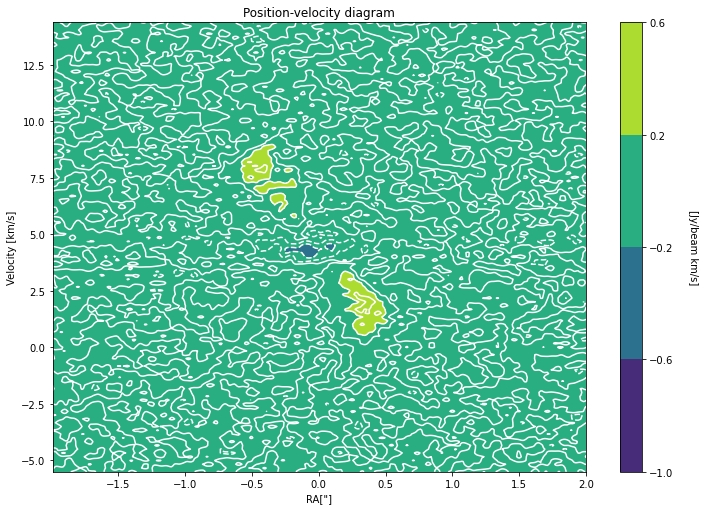

In [38]:
# P-V Diagram
PV = plt.figure(figsize = (10,7))
ke = plt.contourf(x_cen, v_CO, data_CO[:,1960:2040,1800:2200].sum(axis=1),np.arange(-1,1,0.4))
plt.contour(x_cen, v_CO, data_CO[:,1960:2040,1800:2200].sum(axis=1), colors='white')


#colorbar
cbar = plt.colorbar(ke)
cbar.set_label('[Jy/beam km/s]', labelpad=25, y=0.5, rotation=270);

plt.title('Position-velocity diagram')
plt.tight_layout()
plt.xlabel('RA["]')
plt.ylabel('Velocity [km/s]')
#plt.xlim(-2,2)
plt.show();

In [47]:
x_cen.shape

region = xaxis_CO[np.where((xaxis_CO<=1.01) & (xaxis_CO>=-1.01))]
print(region.shape)
#region = -1*region
#print(region)

(201,)


1950
69
2000
59
2050
115


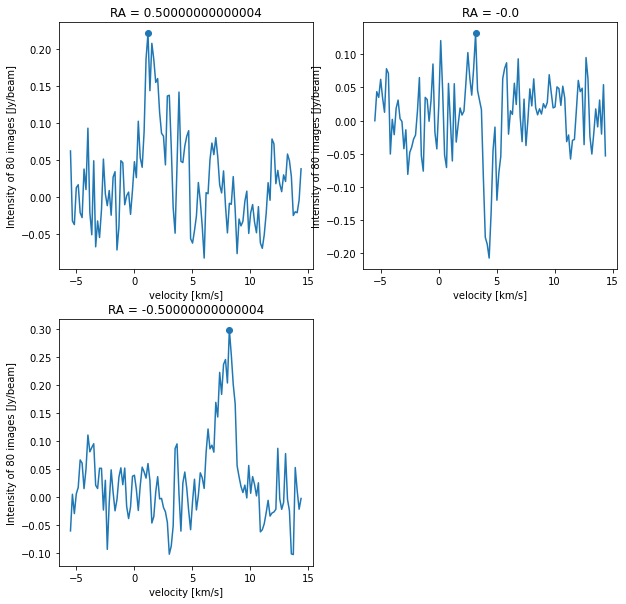

In [48]:
#RAs = [1900:2100]

vel = []
liste = [1950, 2000, 2050]
regionlist = [50, 100, 150]
plt.figure(figsize=(10,10))
for j, item in enumerate(liste):
    print(item)
    intensity = np.zeros((data_CO[:,1960,2050].shape))
    for i in range(80):
        index = 1960+i
        intensity += data_CO[:,index, item]
    vel.append(v_CO[np.argmax(intensity)])
    print(np.argmin(intensity))

    plt.subplot(2,2,j+1); plt.plot(v_CO, intensity)
    plt.scatter(v_CO[np.argmax(intensity)], np.max(intensity))
    plt.xlabel('velocity [km/s]')
    plt.ylabel('Intensity of 80 images [Jy/beam]')
    plt.title(f'RA = {region[regionlist[j]]}')
    #DECs = np.sum(data_CO[:,1960:2040,:])
    #print(DECs)
    #plt.plot(v_CO, data_CO[:,2000,2050]);

    #plt.plot(v_CO, DECs)

In [ ]:
x_right

In [ ]:
x_left

In [ ]:
plt.scatter(x_left, x_right)

In [41]:
X1 = np.concatenate((x_left, x_right))
temp = ((190) * x_cen[159:240])*149597871 # from arcsecs to km (x_cen is in arcsec)
X2 = np.delete(temp, 41)
X3 = np.concatenate((x_right, x_left))

V1 = v_CO[25:105].ravel()

def plot(x, v):
    initial_M = 2e30 
    param_new, cov_new = curve_fit(kepler, x, v, p0=[initial_M])
    fitted_M_new = param_new[0]
    
    Mnew = fitted_M_new * u.kg /M_sun
    print("Fitted Mass_new , Mnew =", Mnew, 'solarmasses')
    
    # P-V Diagram
    PV = plt.figure(figsize = (10,7))
    ke = plt.contourf(x_cen, v_CO-4.5, data_CO[:,1960:2040,1800:2200].sum(axis=1),np.arange(-1,1,0.4))
    plt.contour(x_cen, v_CO-4.5, data_CO[:,1960:2040,1800:2200].sum(axis=1), colors='white')

    plt.plot(x/1e10, kepler(x, fitted_M_new), linestyle='--', linewidth=2, color='blue');


    #colorbar
    cbar = plt.colorbar(ke)
    cbar.set_label('[Jy/beam km/s]', labelpad=25, y=0.5, rotation=270);

    plt.title('P-V diagram with Kepler fit')
    plt.tight_layout()
    plt.xlabel('RA["]')
    plt.ylabel('Velocity [km/s]')
    plt.xlim(-2,2)
    #plt.ylim(-10,10)
    #plt.savefig('PVkepler.png')
    plt.show();


In [42]:
X1 = np.concatenate((x_left, x_right))
temp = ((190) * x_cen[159:240])*149597871 # from arcsecs to km (x_cen is in arcsec)
X2 = np.delete(temp, 41)
X3 = np.concatenate((x_right, x_left))

V1 = v_CO[25:105].ravel()

def plot(x, v):
    initial_M = 2e30 
    param_new, cov_new = curve_fit(kepler, x, v, p0=[initial_M])
    fitted_M_new = param_new[0]
    
    Mnew = fitted_M_new * u.kg /M_sun
    print("Fitted Mass_new , Mnew =", Mnew, 'solarmasses')
    
    # P-V Diagram
    PV = plt.figure(figsize = (10,7))
    ke = plt.contourf(x_cen, v_CO-4.5, data_CO[:,1960:2040,1800:2200].sum(axis=1),np.arange(-1,1,0.4))
    plt.contour(x_cen, v_CO-4.5, data_CO[:,1960:2040,1800:2200].sum(axis=1), colors='white')

    plt.plot(x/1e10, kepler(x, fitted_M_new), linestyle='--', linewidth=2, color='blue');


    #colorbar
    cbar = plt.colorbar(ke)
    cbar.set_label('[Jy/beam km/s]', labelpad=25, y=0.5, rotation=270);

    plt.title('P-V diagram with Kepler fit')
    plt.tight_layout()
    plt.xlabel('RA["]')
    plt.ylabel('Velocity [km/s]')
    plt.xlim(-2,2)
    #plt.ylim(-10,10)
    #plt.savefig('PVkepler.png')
    plt.show();


In [43]:
print(temp)

[ 1.16536742e+10  1.13694382e+10  1.10852022e+10  1.08009663e+10
  1.05167303e+10  1.02324944e+10  9.94825842e+09  9.66402247e+09
  9.37978651e+09  9.09555056e+09  8.81131460e+09  8.52707865e+09
  8.24284269e+09  7.95860674e+09  7.67437078e+09  7.39013483e+09
  7.10589887e+09  6.82166292e+09  6.53742696e+09  6.25319101e+09
  5.96895505e+09  5.68471910e+09  5.40048314e+09  5.11624719e+09
  4.83201123e+09  4.54777528e+09  4.26353932e+09  3.97930337e+09
  3.69506741e+09  3.41083146e+09  3.12659550e+09  2.84235955e+09
  2.55812359e+09  2.27388764e+09  1.98965168e+09  1.70541573e+09
  1.42117977e+09  1.13694382e+09  8.52707865e+08  5.68471910e+08
  2.84235955e+08 -0.00000000e+00 -2.84235955e+08 -5.68471910e+08
 -8.52707865e+08 -1.13694382e+09 -1.42117977e+09 -1.70541573e+09
 -1.98965168e+09 -2.27388764e+09 -2.55812359e+09 -2.84235955e+09
 -3.12659550e+09 -3.41083146e+09 -3.69506741e+09 -3.97930337e+09
 -4.26353932e+09 -4.54777528e+09 -4.83201123e+09 -5.11624719e+09
 -5.40048314e+09 -5.68471

In [44]:
#Use the data, and read about the weight and see if you can find a more deeper explanation!

Fitted Mass_new , Mnew = 0.6285198270026737 solarmasses


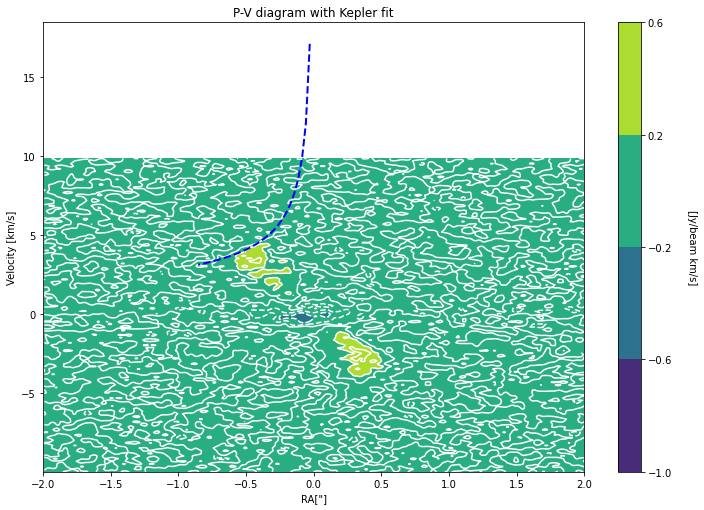

In [45]:
plot(X1[40:70], V1[40:70])

In [ ]:
# kepler fit, skal være et kald, ingen behov for two

In [ ]:
from scipy import interpolate

xx = np.array([350, 450, 850, 1120, 1200, 1200])  # micrometer
yy = [0.101, 0.0619, 0.0182, 0.0114, 0.0102, 0.0102]  # cm^2 g^-1
#f = interpolate.interp1d(xx, yy, fill_value = "extrapolate")
#print(f())


In [ ]:
#plt.plot(xx,yy);
plt.scatter(xx,yy);

In [ ]:
plt.plot(np.log(xx),np.log(yy),'ro');

In [ ]:
def linear_fit(x, a, b):
    return a*x + b

xx = np.log(np.array([350, 450, 850, 1120, 1200, 1200])*1e-4)  # cm, converted from micrometer to cm
yy = np.log(np.array([0.101, 0.0619, 0.0182, 0.0114, 0.0102, 0.0102]))  # cm^2 g^-1
param, cova = curve_fit(linear_fit, xx, yy)
a, b= param
    
next_x = np.log(1300*1e-4)  #[cm]
next_y = linear_fit(next_x, a, b)
new_y = np.exp(next_y)
print('new value of y:', np.round(new_y,7), '[cm^2 g^-1]')
    
plt.plot(xx,yy)
plt.plot(np.append(xx,next_x),np.append(yy, next_y), 'ro')
plt.show()

In [ ]:


m = 2e30

# Define the y data (v_CO) that you want to fit
v_all = kepler(x_all, m)

plt.figure(2, figsize = (15,10))
plt.plot(v_all);
plt.title('all')
plt.xlabel('RA offset ["]')
plt.ylabel('v [km/s]')

plt.show();

In [ ]:


m = 2e30

# Define the y data (v_CO) that you want to fit
v_right = kepler(x_right, m)
v_left =  kepler(x_left,m)

plt.figure(2, figsize = (15,10))

plt.subplot(221)
plt.plot(v_left);

plt.title('Left upper side')
plt.xlabel('RA offset ["]')
plt.ylabel('v [km/s]')

plt.subplot(222)
plt.plot(v_right);

plt.title('Right down side')
plt.xlabel('RA offset ["]')
plt.ylabel('v [km/s]')
plt.show();

In [ ]:
# P-V Diagram
PV = plt.figure(figsize = (10,7))
ke = plt.contourf(x_cen, v_CO,data_CO[:,1960:2040,1800:2200].sum(axis=1),np.arange(-1,1,0.4))
plt.contour(x_cen, v_CO, data_CO[:,1960:2040,1800:2200].sum(axis=1), colors='white')
plt.plot(x_right/1e10, 5+kepler(x_right, fitted_M_right), linestyle='--', linewidth=2, color='blue');
plt.plot(x_left/1e10,  5-kepler(x_left, fitted_M_left), linestyle='--', linewidth=2, color='red');


#colorbar
cbar = plt.colorbar(ke)
cbar.set_label('[Jy/beam km/s]', labelpad=25, y=0.5, rotation=270);

plt.title('P-V diagram with Kepler fit')
plt.tight_layout()
plt.xlabel('RA["]')
plt.ylabel('Velocity [km/s]')
plt.xlim(-2,2)
plt.ylim(-5,14)
#plt.savefig('PVkepler.png')
plt.show();

In [ ]:
# I_obs = Flux * e^-tau

(M_L/100) * 1

# Earth mass
M_E = 5.97219e24 * u.kg  # kilograms
M_dis = M_dust / M_E
M_dis

In [ ]:
#boltzmann distributin, level populotion n = exp(E/k_b T)

M_disc/M_L

M_disc/M_R

(M_R/100)*1

(M_L/100)*1

In [ ]:
7.2e-3

M_L

## Kaufmann mass and column density

In [ ]:
#v_CO  #radial velocity

In [ ]:
bemaj = header['BMAJ']*3600
bemin = header['BMIN']*3600
HPBW = (bemaj + bemin) / 2
HPBW

In [ ]:
#header
#new_y*1000
new_y

In [ ]:

peak = 3.466  # +/- 0.041 mJy/beam - taken from the Gaussian fit values, used in column density
#S_beam = peak # Is it ?
F = 77.37/1e3   # Jy from gaussian fit, used in mass disk
#HPBW = 5.55e-10 # taken from Obs. week 4 excercise, theta_HPBW ca.= pixel size
HPBW = HPBW #this can be read directly from the header, or the Gaussian fit values, <0.05 and 0.07> -> 0.06
#kappa = 1.84  # cm^2 g^-1 From Tobin
kappa = new_y # linear fit
#kappa = 0.0102
lambd = 1.3 # mm, from 1300micrometer to mm
T = 43 #K Tobin
Dis = 193 #pc, 

exp = np.exp((1.439)*((lambd)**(-1))*((T/10)**(-1)))


# Mass
M = 0.12 * (exp - 1) * (kappa/0.01)**(-1) * (F) * (Dis/100)**2 * (lambd)**3  # [M_sun] Here i use the integrated flux
print('Mass disk:',M,'solarmass') #solarmass


# column density
N_H2 = 2.02e20 * (exp - 1) *  (kappa/0.01)**(-1) * peak * ((HPBW/10)**(-2)) * (lambd)**3 # [cm^-2] here i use the peak
print('Column density, N_H2:', N_H2,'cm^-2')





In [ ]:
# dobbelt tjek værdien for kappa, peak ? HPBW...

In [ ]:
FluxT

In [ ]:
# extrapolere dataen fra table 1 Kauffmann, lambda og kappa og finde kappa ved 1300

### Luminosity of the dust

In [ ]:
#creating SED plots over many differenet wavelengths, Jes/Rajeeb has data to do it

In [ ]:
bølgeL = 1
fluxdens = 1 

In [ ]:
# Fv the spectral density along the frequency axis
# Flambda the spectral density along the wavelength axis
# Fv and Flambda shall be equal when integrating between two lambda/freq.
# dv/dlambda = c/lambda**2
# Flambda(lambda) = Fv c/lambda**2
# convention plot -> lambdaFlambda(lambda) = vFv(v)
# because then the curves look the same regardless of whether wavelength or frequency is plotted, 
# and both axes can be placed on the same plot. (nu-Fnu, lambda-Flambda)
#'''if 𝜆 is in nm, and 𝐹𝜆(𝜆) is in 𝑊/𝑛𝑚/𝑚2 (or erg/s/nm/cm^2), then the combined unit is 𝑊/𝑚2
# (or erg/s/cm^2), which is consistent with the right side, if 𝜈 is in Hz, and 𝐹𝜈 is in 𝐽𝑦.'

#''''If luminosity densities are considered, multiplying by the area (𝑚2), 
#'for example 4𝜋×𝐷𝐿 with 𝐷𝐿 the (luminosity) distance, 
#'removes 𝑚2 from the units of 𝐹𝜆(𝜆), and 𝐽𝑦 become 𝐽 for 𝐹𝜈(𝜈)'


 

In [ ]:
from specutils import Spectrum1D
os.getcwd()

In [ ]:

# logfile of the fit
with open(dat+'Ced110IRS4.sed', "r") as f:
    contents = f.read()
    print(contents)

In [ ]:
# importing pandas
import pandas as pd

name = 'Ced110IRS4.sed'
def sed(name):
    # read text file into pandas DataFrame
    df = pd.read_csv(dat+name, sep="\t",skiprows=9)
  
    # display DataFrame
    print('dataframe converted data')
    df = df.sort_values(by='wavelength (mu)')
    print(df)
    print('-----------------------------------------------------------------------------')
    
    print('Wavelength')
    WL = df['wavelength (mu)'].values
    print(WL)
    print('-----------------------------------------------------------------------------')
    
    print('flux_density')
    FD = df['flux_density (mJy)'].values
    print(FD)
    print('-----------------------------------------------------------------------------')
    

    
    # plotting the before and after rotating the data
    plt.figure(2, figsize = (15,10))

    plt.subplot(221)
    plt.scatter(WL, FD);
    plt.title('scatter plot SED')
    plt.ylabel('flux density[mJy]')
    plt.xlabel('wavelength [mu]');



    plt.subplot(222)
    plt.plot(WL, np.log(FD))
    plt.title('SED plot')
    plt.ylabel('flux density[mJy]')
    plt.xlabel('wavelength [mu]');


    plt.show();
    #plt.savefig('rotate.png')


In [ ]:
sed(name)

In [ ]:
#irsa --> sed
# plot edisc  ohashi 2023 SED i appendix

# SED luminosty
# rajeeb- removed abover 1000, do I need them or not?
#longer lambda gives free-free emission, for T and L the peak part is more important

# find the error in mass --> factor 2



In [ ]:
# total flux/energi
## integrstion of all values

In [ ]:
# lange bølgelængde hvor masse og luminosity rundt om kilden er der